# 12.4d: Quantization Lattice Test

**Goal:** Test whether bfloat16 quantization of a float32 vector + noise can produce Qwen-like population distributions.

## Hypothesis

Qwen's black hole population distribution [814, 704, 306, 228, 11, 10, 6, 5, 4, 4, 3, 3, 2] + 111 singletons is caused by:

1. All 2,100 dead tokens initialized to the **same float32 vector** (or tiny variations)
2. **Quantization to bfloat16** causes them to land in different lattice cells
3. The population distribution reflects **bfloat16 lattice geometry** around that random point

## Tests

We'll run 5 tests with different noise scales:
1. **No noise** (sanity check: should give 1 black hole with 2,100 tokens)
2. **Uniform noise U(-ε, +ε)** where ε ≈ 6×10⁻⁵ (one ULP at Qwen's scale)
3. **Gaussian N(0, σ)** where σ = 3×10⁻⁵ (half ULP)
4. **Gaussian N(0, σ)** where σ = 1×10⁻⁴ (couple ULPs)
5. **Gaussian N(0, σ)** where σ = 3.28×10⁻³ (measured from Qwen's dead tokens)

For each test, we'll show:
- Number of unique vectors
- Top 10 population sizes
- Number of singletons
- Spatial extent in units of ε

## Memory Budget

- Matrix: [2100, 2560] × 2 bytes (bfloat16) = 10.8 MB ✓
- Intermediate float32: [2100, 2560] × 4 bytes = 21.5 MB ✓
- **Peak usage: ~50 MB** (well under 24 GB limit)

## Parameters

In [1]:
# Matrix dimensions (matching Qwen)
N_TOKENS = 2100
HIDDEN_DIM = 2560

# Target norm for random vector (matching Qwen's centroid)
TARGET_NORM = 0.166

# Epsilon (bfloat16 ULP at Qwen's scale)
EPSILON = 5.9604645e-05

# Noise scales to test
NOISE_CONFIGS = [
    {'name': 'No noise', 'type': 'none', 'scale': 0.0},
    {'name': 'Uniform ±ε', 'type': 'uniform', 'scale': EPSILON},
    {'name': 'Gaussian σ=0.5ε', 'type': 'gaussian', 'scale': 3e-05},
    {'name': 'Gaussian σ=2ε', 'type': 'gaussian', 'scale': 1e-04},
    {'name': 'Gaussian σ=3.28e-3 (Qwen measured)', 'type': 'gaussian', 'scale': 3.281911e-03},
]

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports complete")

✓ Imports complete


## Generate Base Random Vector

Create one random float32 vector with norm ≈ 0.166 (matching Qwen's centroid).

In [3]:
print("Generating base random vector...\n")

# Generate random vector
randvec = torch.randn(HIDDEN_DIM, dtype=torch.float32)

# Scale to target norm
randvec = randvec / randvec.norm() * TARGET_NORM

print(f"Random vector:")
print(f"  Shape: {randvec.shape}")
print(f"  Dtype: {randvec.dtype}")
print(f"  Norm: {randvec.norm().item():.6f}")
print(f"  Min: {randvec.min().item():.6e}")
print(f"  Max: {randvec.max().item():.6e}")
print(f"  Mean: {randvec.mean().item():.6e}")
print(f"  Std: {randvec.std().item():.6e}")

Generating base random vector...

Random vector:
  Shape: torch.Size([2560])
  Dtype: torch.float32
  Norm: 0.166000
  Min: -1.271948e-02
  Max: 1.143541e-02
  Mean: 2.555833e-05
  Std: 3.281405e-03


## Test Function

In [4]:
def run_quantization_test(randvec, noise_config):
    """
    Run one quantization test:
    1. Create N_TOKENS copies of randvec
    2. Add noise according to config
    3. Quantize to bfloat16
    4. Analyze population distribution
    """
    name = noise_config['name']
    noise_type = noise_config['type']
    scale = noise_config['scale']
    
    # Create copies
    embeddings = randvec.unsqueeze(0).repeat(N_TOKENS, 1)  # [2100, 2560]
    
    # Add noise
    if noise_type == 'uniform':
        noise = torch.rand(N_TOKENS, HIDDEN_DIM, dtype=torch.float32) * 2 * scale - scale
        embeddings = embeddings + noise
    elif noise_type == 'gaussian':
        noise = torch.randn(N_TOKENS, HIDDEN_DIM, dtype=torch.float32) * scale
        embeddings = embeddings + noise
    elif noise_type == 'none':
        pass  # No noise
    
    # Quantize to bfloat16
    embeddings_bf16 = embeddings.to(torch.bfloat16)
    
    # Find unique vectors
    unique_vectors, inverse_indices, counts = torch.unique(
        embeddings_bf16,
        dim=0,
        return_inverse=True,
        return_counts=True
    )
    
    # Sort counts descending
    sorted_counts = torch.sort(counts, descending=True)[0]
    
    # Count singletons and black holes
    n_singletons = (counts == 1).sum().item()
    n_black_holes = (counts >= 2).sum().item()
    
    # Compute spatial extent (L∞ distances between unique vectors)
    if len(unique_vectors) > 1:
        # Use cdist for memory efficiency
        unique_float = unique_vectors.to(torch.float32)
        l_inf_matrix = torch.cdist(unique_float, unique_float, p=float('inf'))
        max_l_inf = l_inf_matrix.max().item()
        max_l_inf_in_ulps = max_l_inf / EPSILON
    else:
        max_l_inf_in_ulps = 0.0
    
    return {
        'name': name,
        'n_unique': len(unique_vectors),
        'n_singletons': n_singletons,
        'n_black_holes': n_black_holes,
        'top_10_counts': sorted_counts[:10].tolist(),
        'max_l_inf_ulps': max_l_inf_in_ulps,
        'counts': counts,
    }

print("✓ Test function defined")

✓ Test function defined


## Run All Tests

In [5]:
print("\nRunning quantization tests...\n")
print("="*80)

results = []

for config in NOISE_CONFIGS:
    result = run_quantization_test(randvec, config)
    results.append(result)
    
    print(f"\nTest: {result['name']}")
    print("-" * 80)
    print(f"  Unique vectors: {result['n_unique']}")
    print(f"  Black holes (count≥2): {result['n_black_holes']}")
    print(f"  Singletons (count=1): {result['n_singletons']}")
    print(f"  Spatial extent: {result['max_l_inf_ulps']:.3f} ULPs")
    print(f"  Top 10 populations: {result['top_10_counts']}")

print("\n" + "="*80)


Running quantization tests...


Test: No noise
--------------------------------------------------------------------------------
  Unique vectors: 1
  Black holes (count≥2): 1
  Singletons (count=1): 0
  Spatial extent: 0.000 ULPs
  Top 10 populations: [2100]

Test: Uniform ±ε
--------------------------------------------------------------------------------
  Unique vectors: 2100
  Black holes (count≥2): 0
  Singletons (count=1): 2100
  Spatial extent: 2.304 ULPs
  Top 10 populations: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Test: Gaussian σ=0.5ε
--------------------------------------------------------------------------------
  Unique vectors: 2100
  Black holes (count≥2): 0
  Singletons (count=1): 2100
  Spatial extent: 4.608 ULPs
  Top 10 populations: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Test: Gaussian σ=2ε
--------------------------------------------------------------------------------
  Unique vectors: 2100
  Black holes (count≥2): 0
  Singletons (count=1): 2100
  Spatial extent: 15.984 ULPs
  To

## Comparison to Qwen

Qwen's actual distribution:
- **Unique vectors:** 124
- **Black holes:** 13
- **Singletons:** 111
- **Spatial extent:** ~1.0 ULP
- **Top populations:** [814, 704, 306, 228, 11, 10, 6, 5, 4, 4, 3, 3, 2]

In [6]:
# Qwen's actual stats
qwen_stats = {
    'n_unique': 124,
    'n_black_holes': 13,
    'n_singletons': 111,
    'max_l_inf_ulps': 1.017,
    'top_10_counts': [814, 704, 306, 228, 11, 10, 6, 5, 4, 4],
}

print("\n" + "="*80)
print("COMPARISON TO QWEN")
print("="*80)

for result in results:
    print(f"\n{result['name']}:")
    print(f"  Unique vectors: {result['n_unique']:>6} (Qwen: {qwen_stats['n_unique']})")
    print(f"  Black holes:    {result['n_black_holes']:>6} (Qwen: {qwen_stats['n_black_holes']})")
    print(f"  Singletons:     {result['n_singletons']:>6} (Qwen: {qwen_stats['n_singletons']})")
    print(f"  Spatial extent: {result['max_l_inf_ulps']:>6.3f} ULPs (Qwen: {qwen_stats['max_l_inf_ulps']:.3f})")
    
    # Check if top 2 are similar
    if len(result['top_10_counts']) >= 2:
        top_2_sum = result['top_10_counts'][0] + result['top_10_counts'][1]
        qwen_top_2_sum = qwen_stats['top_10_counts'][0] + qwen_stats['top_10_counts'][1]
        print(f"  Top 2 sum:      {top_2_sum:>6} (Qwen: {qwen_top_2_sum})")

print("\n" + "="*80)


COMPARISON TO QWEN

No noise:
  Unique vectors:      1 (Qwen: 124)
  Black holes:         1 (Qwen: 13)
  Singletons:          0 (Qwen: 111)
  Spatial extent:  0.000 ULPs (Qwen: 1.017)

Uniform ±ε:
  Unique vectors:   2100 (Qwen: 124)
  Black holes:         0 (Qwen: 13)
  Singletons:       2100 (Qwen: 111)
  Spatial extent:  2.304 ULPs (Qwen: 1.017)
  Top 2 sum:           2 (Qwen: 1518)

Gaussian σ=0.5ε:
  Unique vectors:   2100 (Qwen: 124)
  Black holes:         0 (Qwen: 13)
  Singletons:       2100 (Qwen: 111)
  Spatial extent:  4.608 ULPs (Qwen: 1.017)
  Top 2 sum:           2 (Qwen: 1518)

Gaussian σ=2ε:
  Unique vectors:   2100 (Qwen: 124)
  Black holes:         0 (Qwen: 13)
  Singletons:       2100 (Qwen: 111)
  Spatial extent: 15.984 ULPs (Qwen: 1.017)
  Top 2 sum:           2 (Qwen: 1518)

Gaussian σ=3.28e-3 (Qwen measured):
  Unique vectors:   2100 (Qwen: 124)
  Black holes:         0 (Qwen: 13)
  Singletons:       2100 (Qwen: 111)
  Spatial extent: 494.592 ULPs (Qwen: 1.017)


## Visualization: Population Distributions

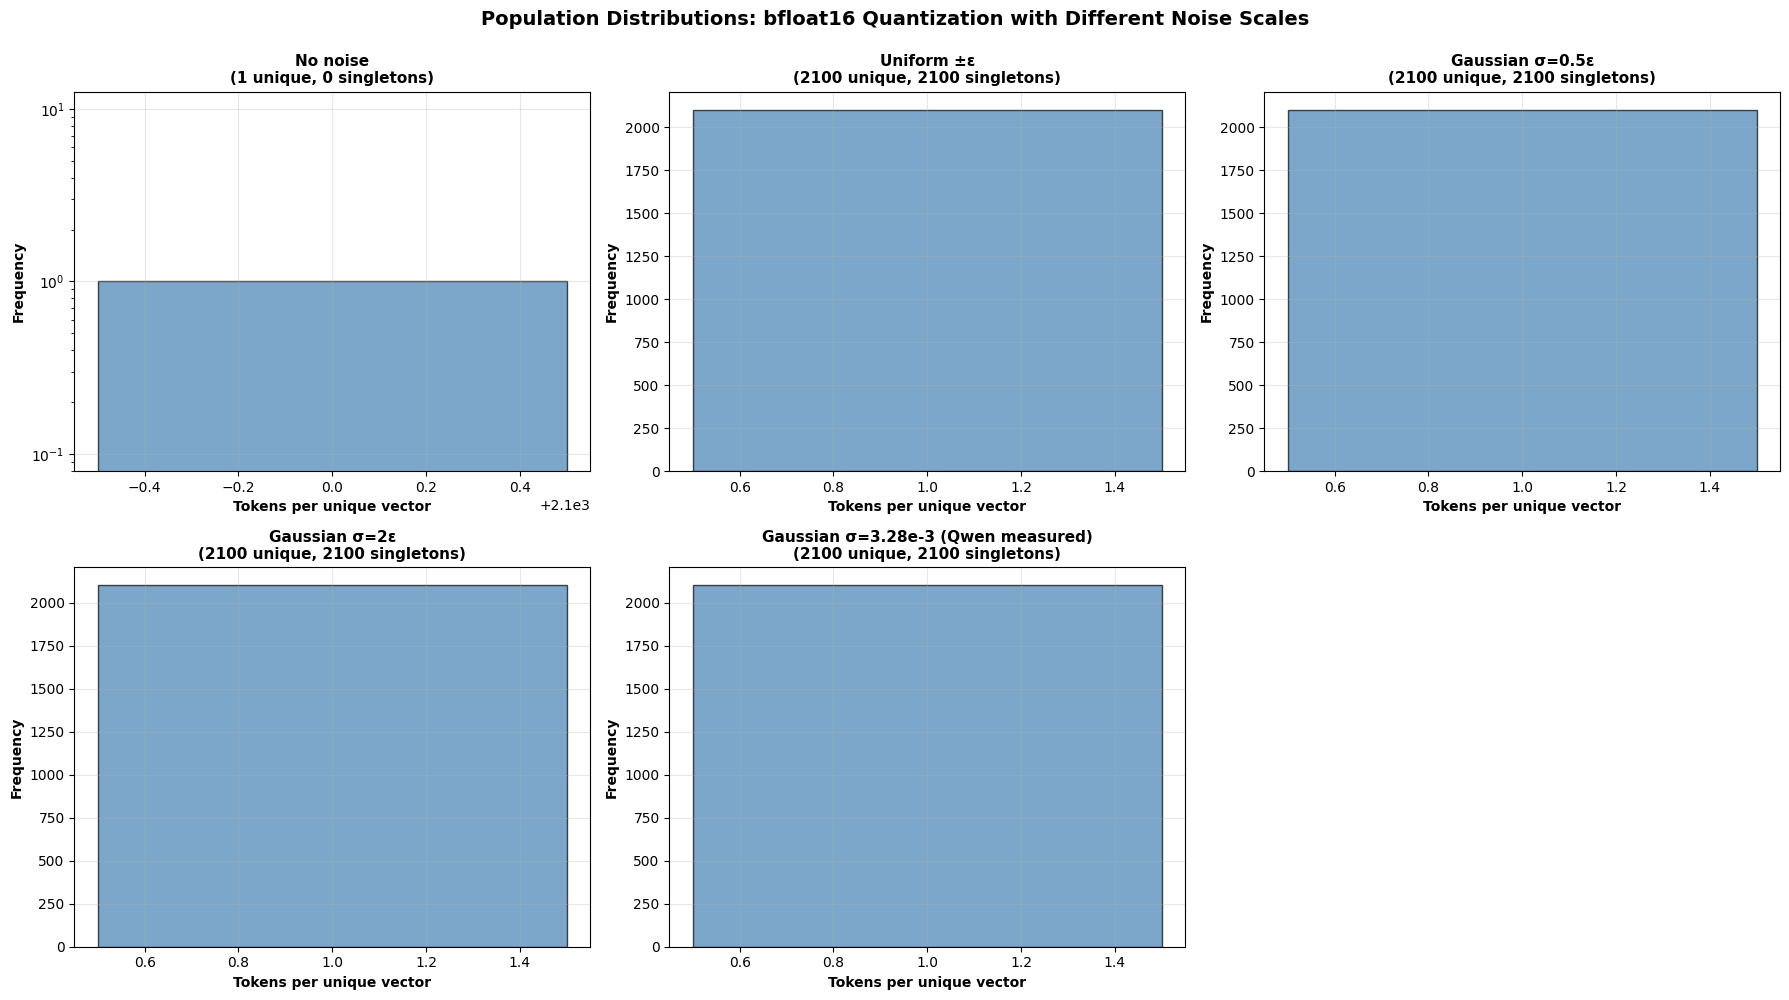

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10), dpi=100)
axes = axes.flatten()

for i, result in enumerate(results):
    ax = axes[i]
    counts_np = result['counts'].cpu().numpy()
    
    # Histogram
    ax.hist(counts_np, bins=min(50, len(np.unique(counts_np))), 
            color='steelblue', alpha=0.7, edgecolor='black')
    
    ax.set_xlabel('Tokens per unique vector', fontsize=10, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=10, fontweight='bold')
    ax.set_title(f"{result['name']}\n({result['n_unique']} unique, {result['n_singletons']} singletons)",
                 fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Log scale if we have large variation
    if counts_np.max() > 100:
        ax.set_yscale('log')

# Hide last subplot (we have 5 tests, 6 slots)
axes[-1].axis('off')

plt.suptitle('Population Distributions: bfloat16 Quantization with Different Noise Scales',
             fontsize=14, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()

## Summary

In [8]:
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
print("\nHypothesis: Qwen's black hole distribution is caused by bfloat16 lattice geometry")
print("\nQwen's pattern:")
print("  - 124 unique vectors (13 black holes + 111 singletons)")
print("  - Two giant black holes: 814 and 704 tokens")
print("  - Spatial extent: ~1 ULP")
print("\nTest results:")

# Find best match
best_match = None
best_score = float('inf')

for result in results:
    # Simple distance metric
    score = (
        abs(result['n_unique'] - qwen_stats['n_unique']) +
        abs(result['n_singletons'] - qwen_stats['n_singletons']) * 0.5 +
        abs(result['max_l_inf_ulps'] - qwen_stats['max_l_inf_ulps']) * 10
    )
    
    if score < best_score:
        best_score = score
        best_match = result

if best_match:
    print(f"\n  Best match: {best_match['name']}")
    print(f"    Unique vectors: {best_match['n_unique']} (vs Qwen's {qwen_stats['n_unique']})")
    print(f"    Singletons: {best_match['n_singletons']} (vs Qwen's {qwen_stats['n_singletons']})")
    print(f"    Spatial extent: {best_match['max_l_inf_ulps']:.3f} ULPs (vs Qwen's {qwen_stats['max_l_inf_ulps']:.3f})")

print("\n" + "="*80)


SUMMARY

Hypothesis: Qwen's black hole distribution is caused by bfloat16 lattice geometry

Qwen's pattern:
  - 124 unique vectors (13 black holes + 111 singletons)
  - Two giant black holes: 814 and 704 tokens
  - Spatial extent: ~1 ULP

Test results:

  Best match: No noise
    Unique vectors: 1 (vs Qwen's 124)
    Singletons: 0 (vs Qwen's 111)
    Spatial extent: 0.000 ULPs (vs Qwen's 1.017)

